> **Results from the best observation experiment.** 

This experiments compares SAC, TD3, and DSAC learning and acting performance in four different environmnets, each with a different observation vector. Each of the three algorithms are trained for \num{10} random seeds in each of the environments. The environments have in commom that the agent should track a sinusoidal pitch rate reference with an \qty{0.1}{} amplitude and the reward function is the squared tracking error. The differences between the environments are detailed in \cref{}.

# ⚙️ Set-up
Loads required packages and set seaborn as plotting style

In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from helpers.paths import Path
from visualization.utils import make_smooth, make_defaults, save_pgf

# Setup defaults for plotting
make_defaults()

Load data

In [2]:
# Load data
df_learn = pd.read_csv(Path.data/"citation-best-observation_learning.csv")
df_ep = pd.read_csv(Path.data/"citation-best-observation_episode.csv")

for _df_to_replace in [df_learn, df_ep]:
    _df_to_replace["observation"].replace({
        "states + ref + error": "OBS-1",
        "error": "OBS-2",
        "state + error": "OBS-4",
        "ref + state": "OBS-3",

    }, inplace=True)

In [3]:
df_learn_smooth = make_smooth(df_learn, step=100, 
                              on="global_step", 
                              columns=["rollout/ep_rew_mean", "rollout/ep_len_mean"],
                              info=["algorithm", "observation"])

# 👨🏽‍🏫 Learning performance

## Averaging all sweeps

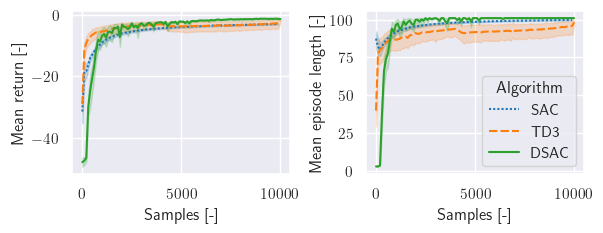

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(6, 2.3))
g = sns.lineplot(data=df_learn_smooth, x="global_step", y="rollout/ep_rew_mean", hue="algorithm", style="algorithm", hue_order=algo_order, ax=ax[0], legend=False)
g.set(xlabel="Samples [-]", ylabel="Mean return [-]");

f = sns.lineplot(data=df_learn_smooth.rename(columns={"algorithm":"Algorithm"}), x="global_step", y="rollout/ep_len_mean", hue="Algorithm", style="Algorithm", hue_order=algo_order, ax=ax[1], legend=True)
f.set(xlabel="Samples [-]", ylabel="Mean episode length [-]");

save_pgf(fig, 'exp2_algorithms.pgf', path="paper")

The image above shows the average of the learning performance of the algorithms in the four studied environments. The graph shows that DSAC is the algorithm that has the highest avereage return. However, this algorithm also shows a slower learning behaviour as TD3 and SAC already rise to high returns at the first samples of the training. With respect to episode length, SAC and DSAC perform comparably, showing that they both learn to control environment during the 100 steps. TD3, however, shows to have a high variance in episode length. Which means some of the times it learns a policy that does can not control the environment during the entire episode. That happens because the pitch rate angles exceed their limit.

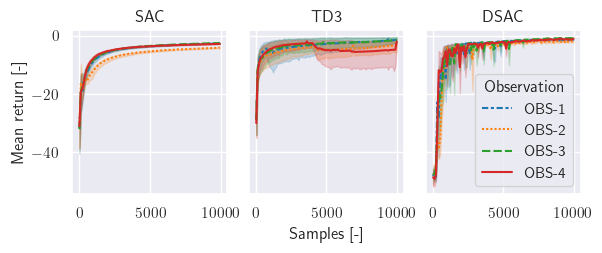

In [14]:
algo_order = ["SAC", "TD3", "DSAC"]
obs_order = [f"OBS-{i}" for i in range(1, 5)]
fig, ax = plt.subplots(1, 3, figsize=(6, 2.5), sharey=True)


for idx, algo in enumerate(algo_order):
    
    g = sns.lineplot(data=df_learn_smooth[df_learn_smooth.algorithm == algo].rename(columns={"observation":  "Observation"}), x="global_step", y="rollout/ep_rew_mean", hue="Observation", style="Observation", hue_order=obs_order, ax=ax[idx], legend=(idx==2))
    g.set(xlabel="");

    ax[idx].set_title(algo)

ax[0].set_ylabel("Mean return [-]")
ax[1].set_xlabel("Samples [-]")

save_pgf(fig, 'exp2_mean_reward.pgf', path="paper")

This view shows the return for each of the algorithms with respect to each observation function. This image clarifies how TD3 performance is affected by the different observation vectors. DSAC is consistent in the return it reaches while DSAC shows different behaviour for OBS-2. 

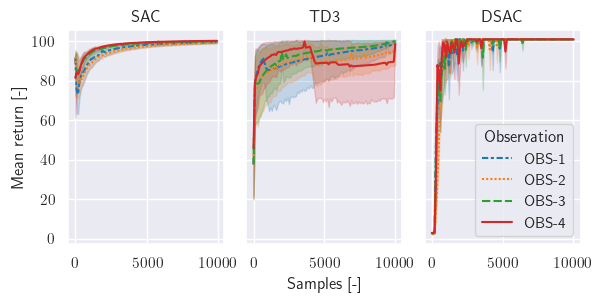

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(6, 3), sharey=True)

for idx, algo in enumerate(algo_order):
    
    g = sns.lineplot(data=df_learn_smooth[df_learn_smooth.algorithm == algo].rename(columns={"observation":  "Observation"}), x="global_step", y="rollout/ep_len_mean", hue="Observation", style="Observation", hue_order=obs_order, ax=ax[idx], legend=(idx==2))
    g.set(xlabel="");

    ax[idx].set_title(algo)

ax[0].set_ylabel("Mean return [-]")
ax[1].set_xlabel("Samples [-]")

save_pgf(fig, 'exp2_mean_length.pgf', path="paper")

The episode length of each algorithm in each observation repeats the information from before. DSAC and SAC learning to control the aircraft independent of the observation vector and TD3 showing that it has a high variance and different behaviour for all observation vectors.

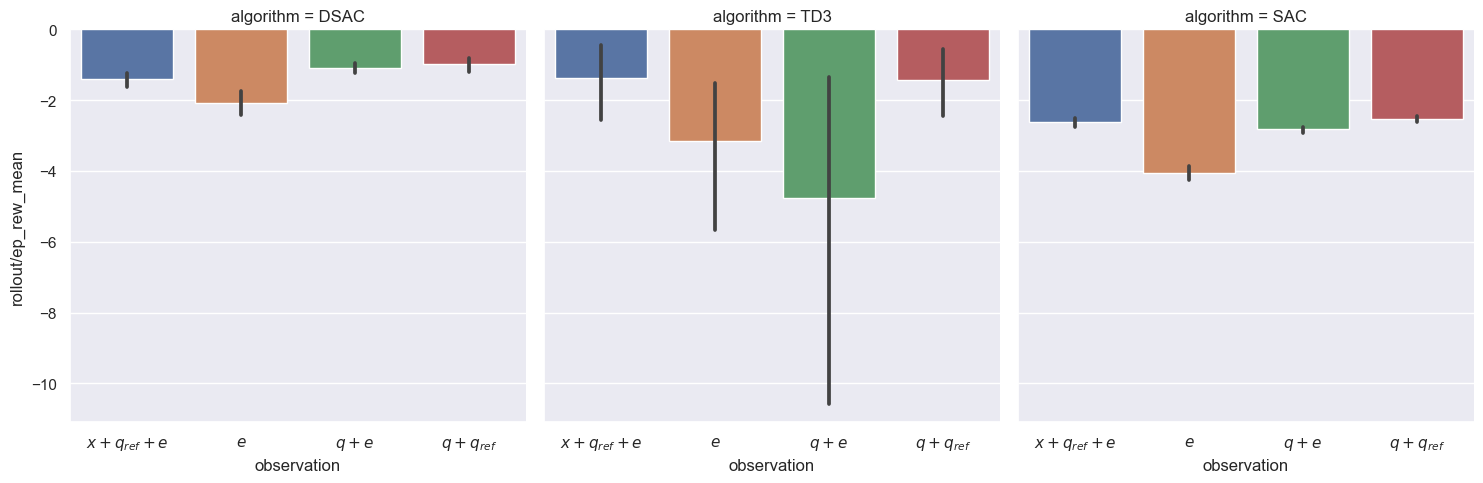

In [8]:
convergence_id = df_learn.groupby(["run"])["global_step"].idxmax().values
sns.catplot(data=df_learn.iloc[convergence_id], x="observation", y="rollout/ep_rew_mean", col="algorithm", kind="bar");

# 📈 Episode analysis

In [7]:
df_ep_runs = df_ep.groupby(["run", "algorithm", "observation"])["tracking_error"].sum().reset_index()

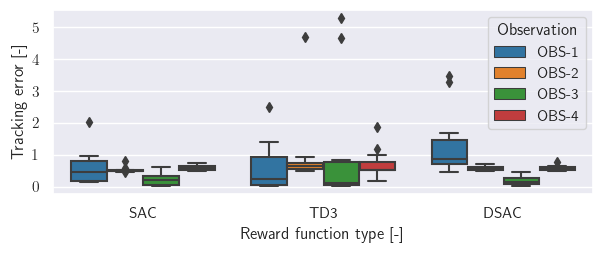

In [16]:
fig, ax = plt.subplots(figsize=(6, 2.5))
sns.boxplot(data=df_ep_runs.rename(columns={"observation": "Observation"}), x="algorithm", y="tracking_error", hue="Observation", order=algo_order, hue_order=obs_order, ax=ax);
ax.set_xlabel("Reward function type [-]")
ax.set_ylabel("Tracking error [-]")

save_pgf(fig, 'exp2_episode_tracking.pgf', path="paper")

Consistent for the three algorithms, OBS-3 is the one with the lowest mean tracking error. In the four environments TD3 has a lower mean tracking error than the other two algorithms. However, it also has the higher variance in all scenarios. Therefore, while it in average can perform better, it the most inconsistant with results being able to show significant undesirable behaviour. 
A curious fact is that OBS-1, which effectivly provides the agent with all informationa bout the environment did not always had a lower tracking error mean than the other observation vectors. The reason for that could be that by having a longer size observation requires the agent to learns longer. Therefore, this observation vector could perform bettwe with more learning time.

Another intersting result is that OBs-3 was consistently better than OBs-4. The reason for that could be that building the OBS-4 some information is lost. Because the tracking error is in fact the squared error, the algorithm misses the information on weather it is over or underestimating the tracked reference. On the other hand OBS-3 provides the agent with the value of the reference and the value of the state. This way the algorithm can perceive better the estimation error.
